#  ICA algorithms, other rotation methods

Week 13 - Group 1

# What ICA Does (recap)

![image](https://www.baeldung.com/wp-content/uploads/sites/4/2023/01/coctel_party.png)

Imagine you’re at a cocktail party with several people talking at once. If you record the sound with multiple microphones, each microphone picks up a mixture of all voices. ICA’s job is to take these mixed signals and separate them back into individual voices, without knowing beforehand what the voices sound like.
It works by finding a mathematical transformation that makes the separated signals as statistically independent as possible.
Figure from: https://www.baeldung.com/cs/independent-component-analysis



#Applications of ICA

* Biomedical: Removing artifacts (eye blinks, muscle noise) from EEG or fMRI data.
* Audio Processing: Separating instruments or voices from mixed recordings.
* Image Processing: Unmixing overlapping images or removing noise.
* Finance: Extracting independent trends from market data.
* Telecom: Reducing interference in wireless signals.

# ICA, a rotative algorithm?

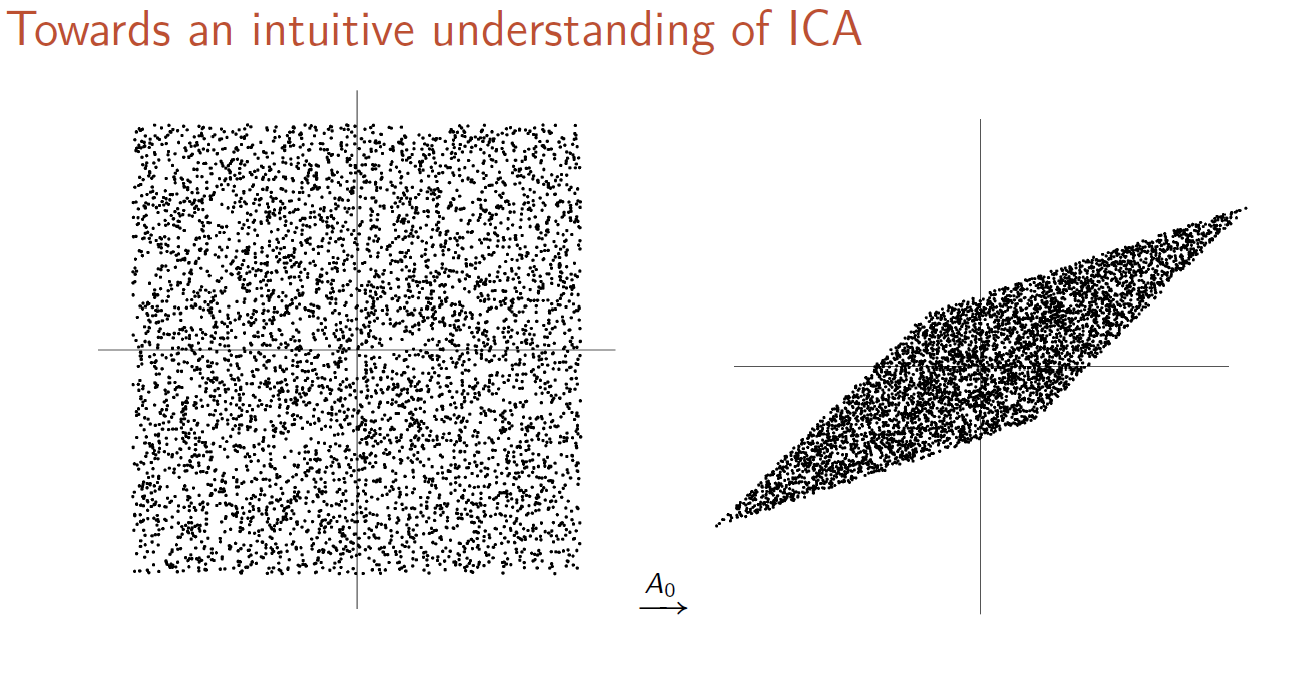

**Find a matrix A that estimate A0**

https://medium.com/data-science/introduction-to-ica-independent-component-analysis-b2c3c4720cd9

![](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*vD76vLy6P7C4WlIjxowmGQ.png)

As you can see, we can determine the inverse matrix A using only the two angles and the variances of the data, which is actually all we need to process the ICA algorithm. Take the measurements, rotate, and scale them. And finally, we rotate them again to get the final dimension.

# Different ICA algorithms
https://mne.tools/stable/auto_examples/preprocessing/ica_comparison.html

## An example - Comparison of time and output (brain activity):


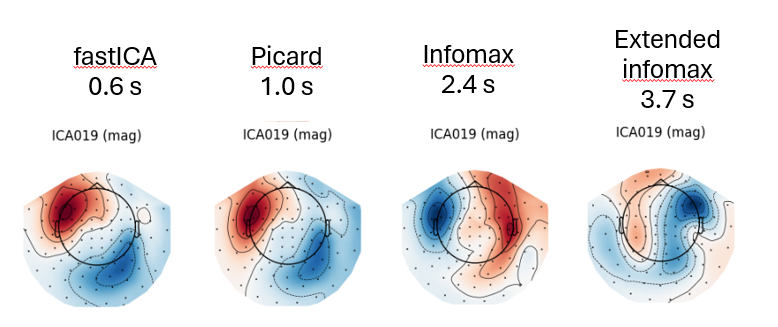

_Read more_:
Test 20 different ICA algorithms: https://sccn.ucsd.edu/~arno/mypapers/delorme_unpub.pdf


## Reliability

**Quality index**
The same algorithm can return different results for successive runs on the same volume of data. Some methods such as ICASSA, RAICAR, and spatial correlation coefficients can be used to examine the reliability of different ICA algorithm.

_Read more_:
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0270556

# ICA vs PCA

![](https://drive.google.com/uc?export=view&id=1SR3Ux7LXKWbbx1Eqdy45YPuwes8WlZKN)

# ICA vs PCA, a coding example

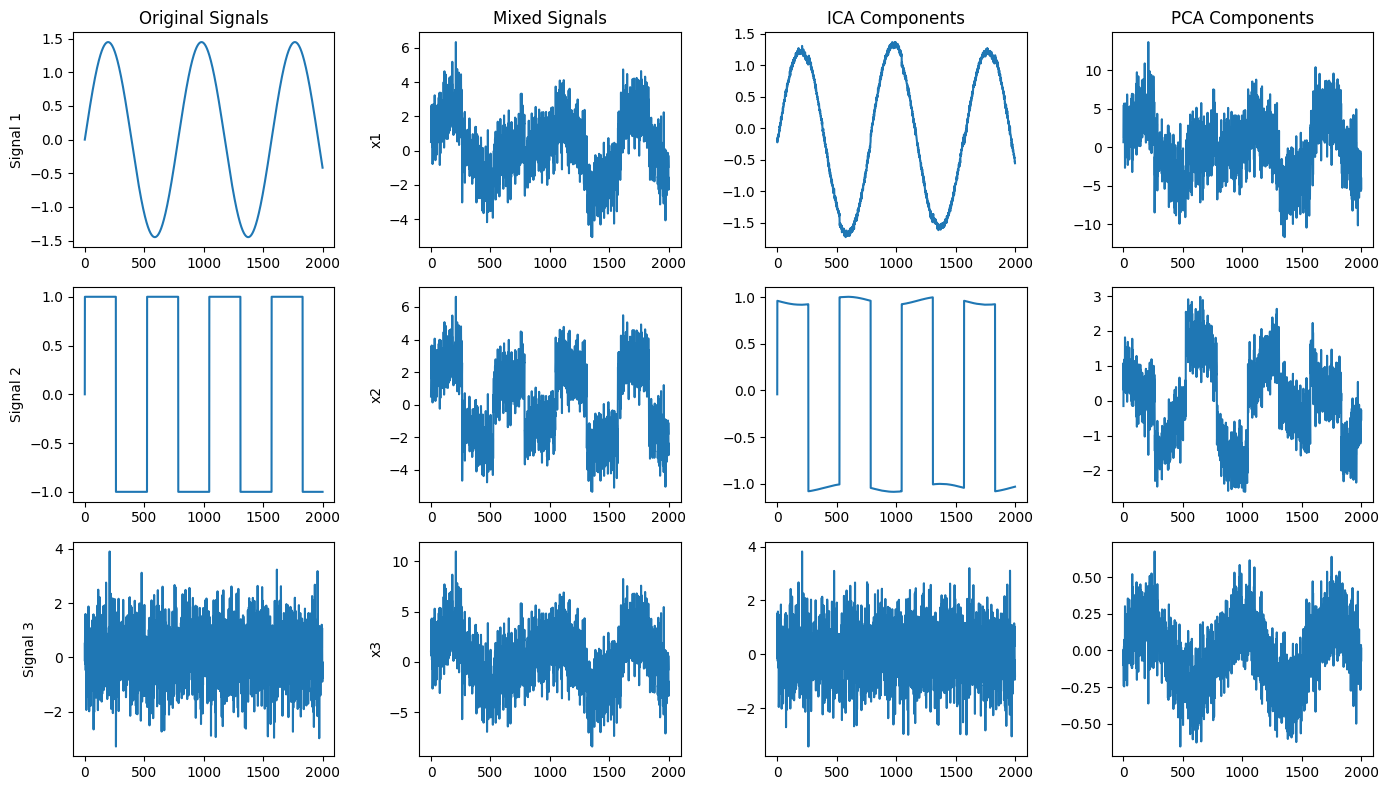

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA

# Generate synthetic signals
np.random.seed(42)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)          # Signal 1
s2 = np.sign(np.sin(3 * time)) # Signal 2
s3 = np.random.normal(size=n_samples) # Signal 3

S = np.c_[s1, s2, s3]
S /= S.std(axis=0)

# Mix signals
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])
X = S.dot(A.T)

# Apply PCA and ICA
pca = PCA(n_components=3)
S_pca = pca.fit_transform(X)

ica = FastICA(n_components=3, random_state=42)
S_ica = ica.fit_transform(X)

# Create 3x4 grid: Original | Mixed | ICA | PCA
fig, axes = plt.subplots(3, 4, figsize=(14, 8))
titles = ["Original Signals", "Mixed Signals", "ICA Components", "PCA Components"]

for i in range(3):
    # Original signals
    axes[i, 0].plot(S[:, i])
    axes[i, 0].set_title(titles[0] if i == 0 else "")
    axes[i, 0].set_ylabel(f"Signal {i+1}")

    # Mixed signals
    axes[i, 1].plot(X[:, i])
    axes[i, 1].set_title(titles[1] if i == 0 else "")
    axes[i, 1].set_ylabel(f"x{i+1}")

    # ICA components
    axes[i, 2].plot(S_ica[:, i])
    axes[i, 2].set_title(titles[2] if i == 0 else "")

    # PCA components
    axes[i, 3].plot(S_pca[:, i])
    axes[i, 3].set_title(titles[3] if i == 0 else "")

plt.tight_layout()
plt.show()


# ICA vs Rotation methods

There are (at least) two different goals we might have:

1. **Explain / interpret the variables**  
   - **Classical rotation methods** (Varimax, Promax, etc.)

2. **Separate underlying sources**  
   - Recover hidden signals that are as **independent** as possible. **Independent Component Analysis (ICA)**.

Both start from linear combinations of the same data, and both can be seen as choosing a **rotation** of some initial components (often after PCA/whitening).  

- **Rotation methods** choose the rotation that makes the *loadings* simple and easy to explain.  
- **ICA** chooses the rotation that makes the *components* as statistically independent as possible.


## Toy example: when separation matters more than explanation

- **3 independent sources**  
  - **Source 1 (S1)**: smooth sine wave.  
  - **Source 2 (S2)**: a square-ish wave, independent process.  
  - **Source 3 (S3)**: an “artifact-like” source.

- **5 observed variables** (X1–X5), each a mixture of these sources:  
  - **X1, X2** are mainly driven by **S1** (plus some S2).  
  - **X3, X4** are mainly driven by **S2** (plus some S1).  
  - **X5** is mainly driven by **S3**, but with some S1/S2 mixed in.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA

np.random.seed(42)

# ==========================
# 1. Generate toy data (3 sources, 5 variables)
# ==========================

n_samples = 3000
t = np.linspace(0, 10, n_samples)

# Main independent sources
S1 = np.sin(2 * np.pi * 0.5 * t)                 # smooth sine
S2 = np.sign(np.sin(2 * np.pi * 1.5 * t))        # square-ish, non-Gaussian

# Artifact / fault source S3:
# - baseline jitter (small Gaussian noise)
# - moderate spikes with amplitude comparable to S1/S2
S3 = 0.3 * np.random.randn(n_samples)            # noisy baseline
spike_indices = np.random.choice(n_samples, size=int(0.05 * n_samples), replace=False)
S3[spike_indices] += np.sign(np.random.randn(len(spike_indices))) * 1.0  # spikes in [-1, 1] added

S = np.vstack([S1, S2, S3]).T  # shape: (n_samples, 3)

# True mixing from 3 sources to 5 observed variables
# X1, X2 mainly S1; X3, X4 mainly S2; X5 mostly S3 + some S1/S2
L_true = np.array([
    [1.0, 0.3, 0.0],   # X1
    [0.8, 0.1, 0.0],   # X2
    [0.2, 1.0, 0.0],   # X3
    [0.1, 0.9, 0.0],   # X4
    [0.3, 0.3, 0.8],   # X5: artifact + some S1/S2
])  # (5 x 3)

noise = 0.1 * np.random.randn(n_samples, 5)
X = S @ L_true.T + noise  # shape: (n_samples, 5)

# Standardize observed variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

variable_names = ["X1", "X2", "X3", "X4", "X5"]

# ==========================
# 2. PCA (3 components)
# ==========================

pca = PCA(n_components=3)
X_pca_scores = pca.fit_transform(X_scaled)  # (n_samples, 3)

# PCA "loadings" (variables x components)
L_pca = pca.components_.T  # (5 x 3)

# ==========================
# 3. Varimax rotation on PCA loadings
# ==========================

def varimax(Phi, gamma=1.0, q=20, tol=1e-6):
    """
    Varimax rotation.
    Phi: loadings matrix (variables x factors)
    Returns: rotated loadings, rotation matrix
    """
    p, k = Phi.shape
    R = np.eye(k)
    d = 0
    for i in range(q):
        d_old = d
        Lambda = Phi @ R
        u, s, vh = np.linalg.svd(
            Phi.T @ (Lambda**3 - (gamma / p) * Lambda @ np.diag(np.diag(Lambda.T @ Lambda)))
        )
        R = u @ vh
        d = np.sum(s)
        if d_old != 0 and (d - d_old) < tol * d_old:
            break
    return Phi @ R, R

L_varimax, R_varimax = varimax(L_pca)

# Rotate PCA scores with the same rotation matrix
X_pca_varimax_scores = X_pca_scores @ R_varimax  # (n_samples, 3)

# ==========================
# 4. ICA (FastICA, 3 components)
# ==========================

ica = FastICA(n_components=3, random_state=42, whiten="unit-variance")
S_ica = ica.fit_transform(X_scaled)  # estimated independent components; (n_samples, 3)

# ICA mixing matrix: variables x components (like a loading matrix)
L_ica = ica.mixing_  # (5 x 3)

# ==========================
# 5. Align components to true loadings (permutation + sign)
# ==========================

import itertools

def align_to_reference(L, scores, L_ref):
    """
    Align columns of L (variables x components) to L_ref by
    trying all permutations and sign flips, minimizing Frobenius norm.
    Apply same transform to scores (samples x components).
    """
    n_comp = L.shape[1]
    best_cost = np.inf
    best_L = None
    best_scores = None

    indices = list(range(n_comp))
    for perm in itertools.permutations(indices):
        P = np.eye(n_comp)[:, perm]  # permutation matrix
        for signs in itertools.product([1, -1], repeat=n_comp):
            D = np.diag(signs)
            T = P @ D  # overall transform
            L_candidate = L @ T
            cost = np.linalg.norm(L_candidate - L_ref)
            if cost < best_cost:
                best_cost = cost
                best_L = L_candidate
                best_scores = scores @ T if scores is not None else None
    return best_L, best_scores

# Align PCA, Varimax, and ICA to the true loadings
L_pca_aligned, X_pca_scores_aligned = align_to_reference(L_pca, X_pca_scores, L_true)
L_varimax_aligned, X_pca_varimax_scores_aligned = align_to_reference(L_varimax, X_pca_varimax_scores, L_true)
L_ica_aligned, S_ica_aligned = align_to_reference(L_ica, S_ica, L_true)

# ==========================
# 6. Helper plotting functions
# ==========================

def plot_method_with_variables(method_name, scores, component_color="tab:orange"):
    """
    scores: (n_samples, 3) -> component time series already aligned:
        comp1 ~ S1 (X1,X2)
        comp2 ~ S2 (X3,X4)
        comp3 ~ S3 (X5)
    component_color: color for the component line (softer than black).
    """
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    # Component 1 with X1 and X2
    axes[0].set_title(f"{method_name}: Component 1 with X1 and X2")
    axes[0].plot(t, X_scaled[:, 0], alpha=0.5, label="X1")
    axes[0].plot(t, X_scaled[:, 1], alpha=0.5, label="X2")
    axes[0].plot(t, scores[:, 0], linewidth=1.5, color=component_color, label="Component 1")
    axes[0].legend(loc="upper right")
    axes[0].set_ylabel("Value")

    # Component 2 with X3 and X4
    axes[1].set_title(f"{method_name}: Component 2 with X3 and X4")
    axes[1].plot(t, X_scaled[:, 2], alpha=0.5, label="X3")
    axes[1].plot(t, X_scaled[:, 3], alpha=0.5, label="X4")
    axes[1].plot(t, scores[:, 1], linewidth=1.5, color=component_color, label="Component 2")
    axes[1].legend(loc="upper right")
    axes[1].set_ylabel("Value")

    # Component 3 with X5
    axes[2].set_title(f"{method_name}: Component 3 with X5 (artifact-like)")
    axes[2].plot(t, X_scaled[:, 4], alpha=0.5, label="X5")
    axes[2].plot(t, scores[:, 2], linewidth=1.5, color=component_color, label="Component 3")
    axes[2].legend(loc="upper right")
    axes[2].set_ylabel("Value")
    axes[2].set_xlabel("Time")

    plt.tight_layout()
    plt.show()


def plot_loadings(ax, L, title):
    """
    L: (variables x components)
    """
    n_vars, n_comp = L.shape
    x = np.arange(n_vars)
    width = 0.2
    for j in range(n_comp):
        ax.bar(x + j*width, L[:, j], width=width, label=f"Comp {j+1}")
    ax.set_xticks(x + width * (n_comp - 1) / 2)
    ax.set_xticklabels(variable_names)
    ax.axhline(0, color="black", linewidth=0.8)
    ax.set_title(title)
    ax.legend(fontsize=8)


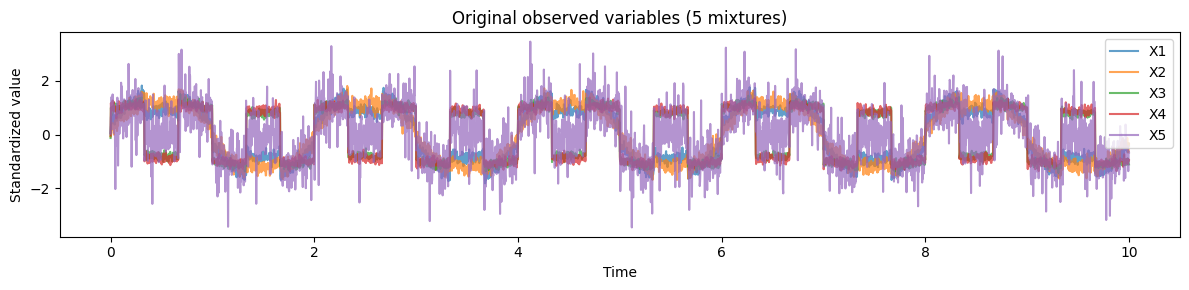

In [ ]:
# Original observed variables (all overlapped)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.set_title("Original observed variables (5 mixtures)")
for i in range(5):
    ax.plot(t, X_scaled[:, i], alpha=0.7, label=variable_names[i])
ax.legend(loc="upper right")
ax.set_ylabel("Standardized value")
ax.set_xlabel("Time")
plt.tight_layout()
plt.show()


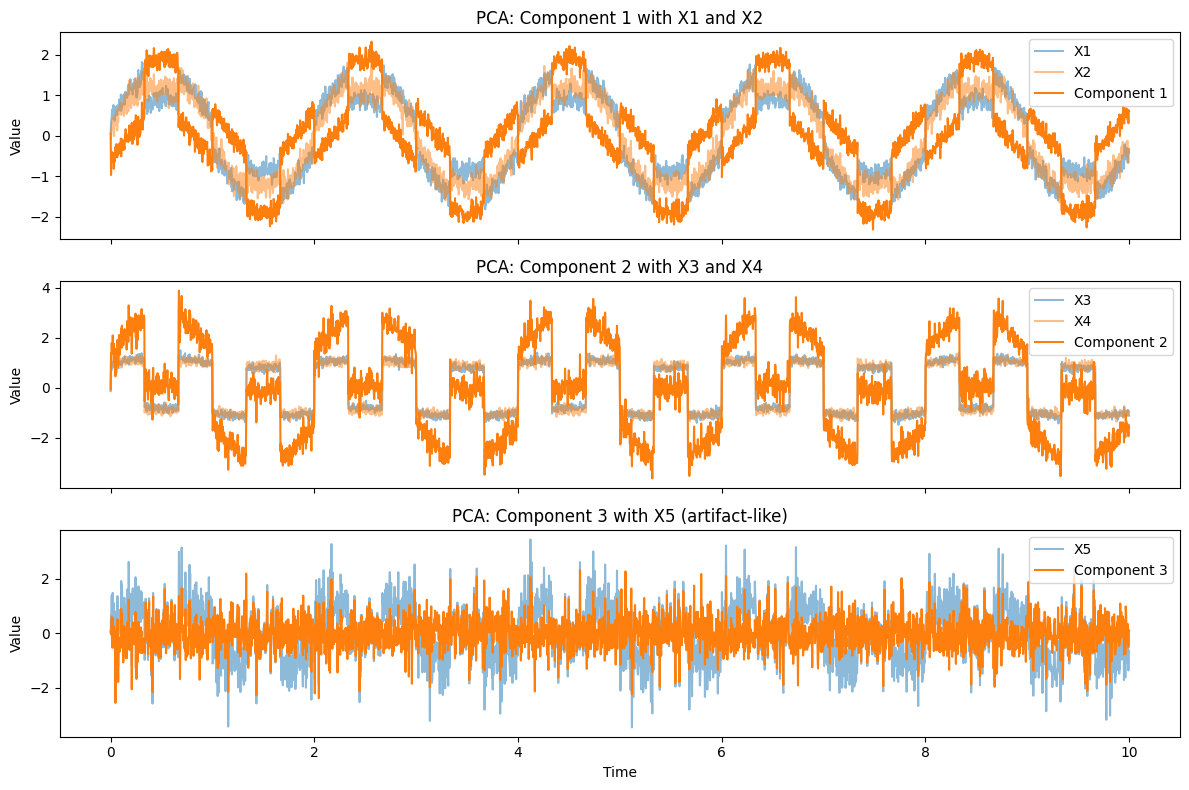

In [ ]:
# PCA: each component overlaid with the variables it mostly explains
plot_method_with_variables("PCA", X_pca_scores_aligned)


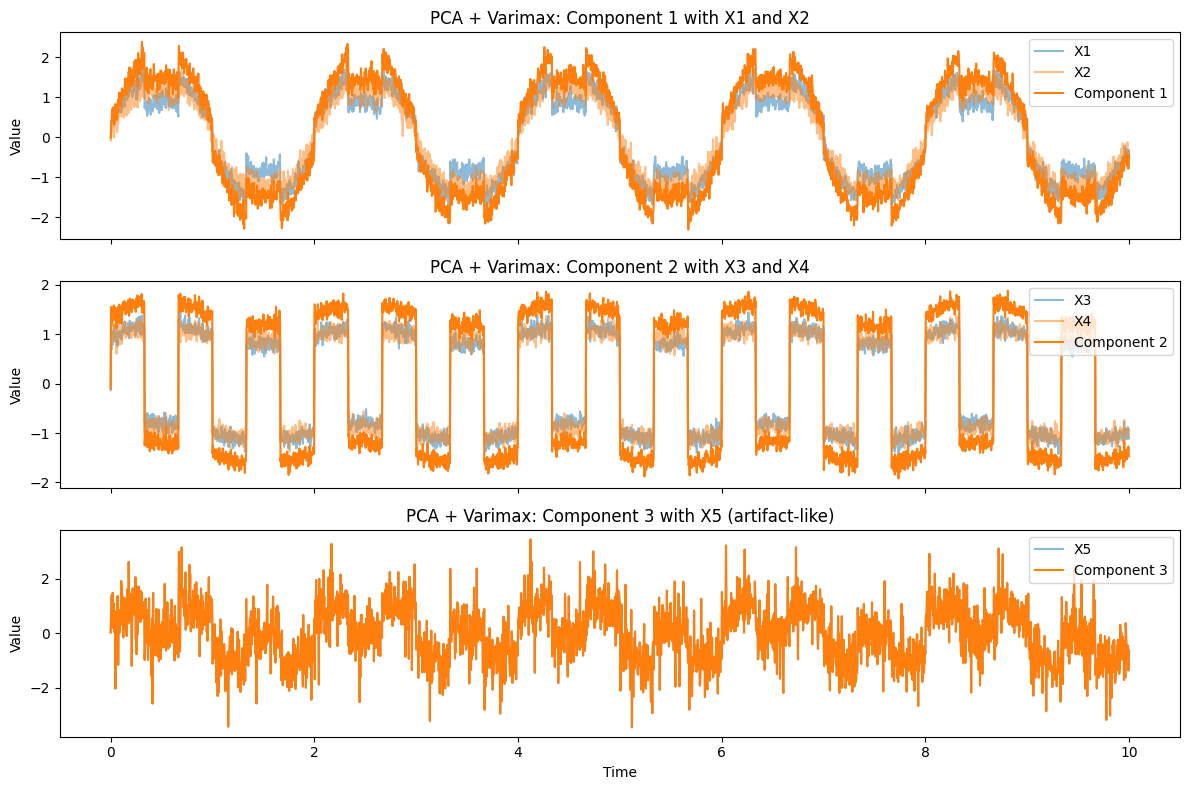

In [ ]:
# PCA + Varimax: traditional rotation for interpretability
plot_method_with_variables("PCA + Varimax", X_pca_varimax_scores_aligned)


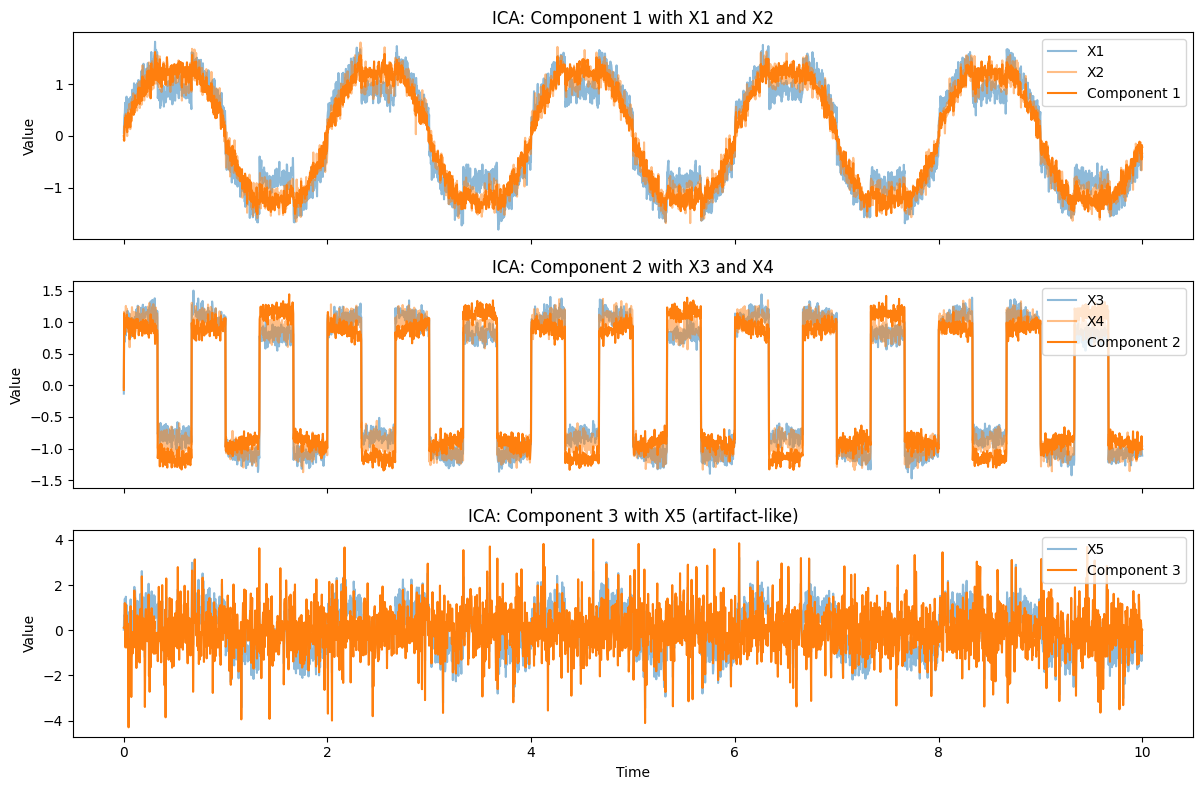

In [ ]:
# ICA: independent components (separation)
plot_method_with_variables("ICA", S_ica_aligned)


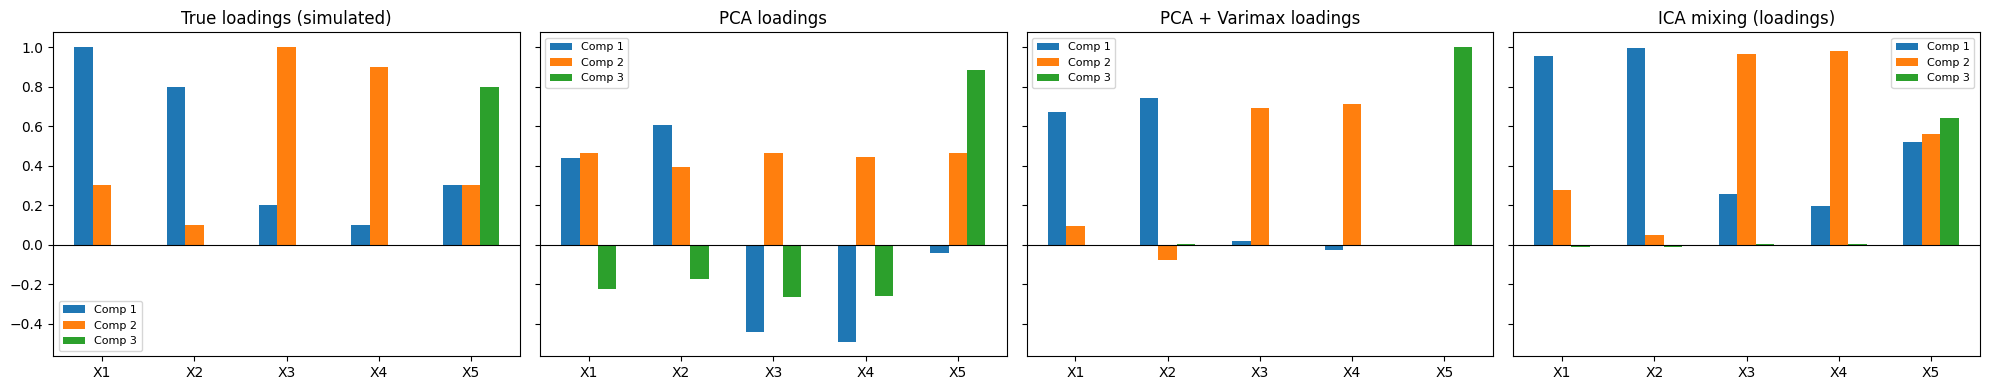

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharey=True)

plot_loadings(axes[0], L_true,            "True loadings (simulated)")
plot_loadings(axes[1], L_pca_aligned,     "PCA loadings")
plot_loadings(axes[2], L_varimax_aligned, "PCA + Varimax loadings")
plot_loadings(axes[3], L_ica_aligned,     "ICA mixing (loadings)")

plt.tight_layout()
plt.show()


Sources:

- https://www.baeldung.com/cs/independent-component-analysis
- https://www.numberanalytics.com/blog/ica-real-world-applications-computer-science